# Building NLP Applications with Hugging Face

In this project I will perform common Natural Language Processing (NLP) tasks using Hugging Face. Some of these tasks include:
- **sentiment analysis** (i.e. categorizing text as negative or positive)
- **text embedding** (i.e. transforming a piece of text into a numerical, n-dimensional vector, representation)
- **semantic search** (i.e. matching a query with the most appropriate result based on embeddings)

The dataset comes from "Rent the Runway" [link](https://cseweb.ucsd.edu//~jmcauley/datasets.html#clothing_fit) and is comprised of user reviews on clothing items, their ratings on fit, and other metadata about the user (i.e. gender, height, size, age, reason for renting) and the item (i.e. category).

## Task 0: Setup

For this project, we will need several Python packages:
- `pandas`
- `numpy`
- `datetime`
- `re`
- `string`
- `matplotlib.pyplot`
- `seaborn`
- `transformers`
- `sentence_transformers`

These packages will help us with the data preprocessing steps, visualization, and for NLP tasks using Hugging Face the `transformers` and `sentence_transformers` packages.

Import necessary libraries.

In [1]:
# Import the other required packages and modules.
import pandas as pd
import numpy as np
import datetime, re, string
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search

# From the IPython.display package, import display and Markdown
from IPython.display import display, Markdown

2025-05-29 09:38:08.301488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 1: Import the Runway Data

The runway data is contained in a CSV file named `runway.csv`.

The dataset contains the following columns.

- `user_id`: the unique identifier for the user.
- `item_id`: the unique identifier for the item/product rented.
- `rating`: the rating by the user.
- `rented_for`: the reason the item was rented.
- `review_text`: the actual text for the submitted user review.
- `category`: the category of the item rented.
- `height`: the height of the user in the format {feet}'{inches}".
- `size`: the size of the item rented by the user.
- `age`: the age of the user.
- `review_date`: the date the review was made by the user.

### Instructions

Import the runway data to a pandas dataframe.

- Read the data from `runway.csv`, making sure to parse the date column. |Assign to `runway`.
- Print the column info

In [7]:
# Read the data from runway.csv
runway = pd.read_csv('runway.csv', parse_dates=['review_date'])

In [9]:
# Print the column info
runway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB


In [11]:
display(runway.sample(5))

,user_id,item_id,rating,rented for,review_text,category,height,size,age,review_date
1153,769732,1113191,10,wedding,the dress fit wellboth theandi went with the l...,dress,"5' 3""",20,33.0,2019-08-31
588,946138,1626903,8,wedding,as others have said it runs a bit long for a s...,dress,"5' 2""",4,31.0,2021-11-19
1200,54595,132738,10,formal affair,really excellent dress i got it was a backup a...,gown,"5' 10""",5,24.0,2017-10-23
92,7186,883661,10,wedding,loved the fabric it was a great material and t...,dress,"5' 4""",4,26.0,2021-07-13
742,465832,139086,10,formal affair,i was very worried about this dress being too ...,gown,"5' 2""",24,35.0,2018-01-20


## Task 2: Preprocessing the `review_text`

Most unstructured text, such as reviews for products, are messy. They contain special characters which may not be necessary, extra spaces, irrelevant digits, and more. Therefore, it is common practice to process, or clean, the text before performing NLP tasks on it.

We will create several processing steps for the `review_text` strings by removing special characters, numbers and digits.
Latter on the project we will check if this step was necessary given new models work wonders.

We will follow the next steps to clean our data:
- replace the special character "/" with a space;
- remove punctuations;
- remove digits;
- replace runs of whitespace, i.e. more than one in a row, with no space; and
- make lowercase.

Apply these changes to the `review_text` column in the `runway` dataset. 

Save as a new column called `review_text_cleaned`.

In [16]:
# save clean text in new column
# Remove the forward-slash character
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\/", "")

# Remove punctuation
runway['review_text_cleaned'] = runway['review_text'].str.translate(string.punctuation)

# Remove digits
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\d+", "")

# Remove running spaces, two or more spaces. single spaces are ok
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\s{2,}", "")

# Make the text lowercase
runway['review_text_cleaned'] = runway['review_text'].str.lower()

## Task 3: Sentiment Analysis on `review_text_cleaned`

In this project with sentiment analysis we will categorize reviews into two buckets - negative or positive. Some models on Hugging Face have the ability to categorize text as neutral as well. 

Sentiment analysis is a common, and useful, NLP task performed in a typical business settings. It can help decision makers determine trends in product or service perception, customer experience, reviews, and more. 

In this task, you will use the `pipeline()` function with the ["distilbert-base-uncased-finetuned-sst-2-english"](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) pre-trained model. This is a smaller general-purpose language representation model that is great at text classification (i.e. sentiment analysis).

We will use `pipeline()` function to achieve the following:

- Instantiate a new pipeline object for `sentiment-analysis`. Save as `sentimentAnalysis`.
- Use this with a list of the cleaned review text as the input to return sentiment for each review. Save the output as `sent_analysis_output`.

Note that this task is computationally intensive and may take several minutes to run. It runs faster in gpu-enable workspace but I lack one :(

In [23]:
model = "distilbert-base-uncased-finetuned-sst-2-english"

# Instantiate the new pipeline() object for sentiment analysis. Include the model defined above as the model input.
sentimentAnalysis = pipeline('sentiment-analysis', model=model)

# Run sentiment analysis on the cleaned review text. Must be on a list
sent_analysis_output = sentimentAnalysis(list(runway['review_text_cleaned']))

Device set to use cpu


## Task 4: Histogram of Sentiment Score

We can use a histogram to understand visually how the sentiment of reviews is distributed amongst rented items on our dataset.

Steps to follow:
- Parse the output of `sent_analysis_output` into two new columns - `clean_sentiment_category` and `clean_sentiment_score`.
- Use `seaborn` to plot score versus reviews to visualize sentiment score distribution:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


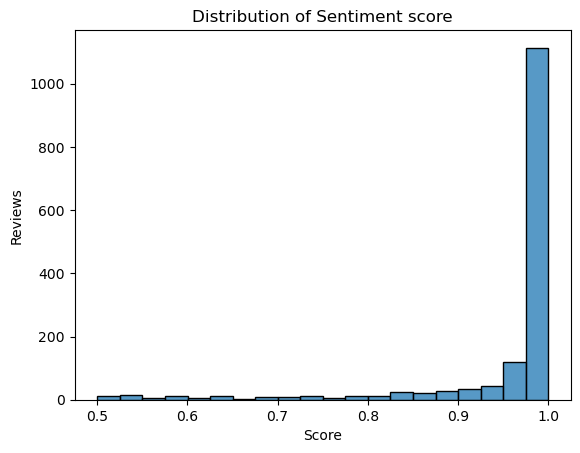

In [28]:
# Parse out the two pieces of output from sent_analysis_output - "label" and "score".
runway['clean_sentiment_category'] = [s['label'] for s in sent_analysis_output]
runway['clean_sentiment_score'] = [s['score'] for s in sent_analysis_output]

# Create the first histogram using the built-in Pandas histogram method.
sns.histplot(data=runway, x='clean_sentiment_score', bins=20)
plt.title('Distribution of Sentiment score')
plt.xlabel('Score')
plt.ylabel('Reviews')
plt.show()


## Task 5: Sentiment Over the Years

The distribution is informative from a global perspective - i.e., the reviews skew positive ("great customer experience"). However, it doesn't tell a complete story.

Now that you have sentiment, you can explore the trends of sentiment across different facets of the data (i.e. over time, between products, etc.). Dissecting the data in this way, based on the business questions of interest, will explain more about what is going well and what needs improvement.

In this task, we will explore how sentiment changed over the years through a bar plot visualization.

- Create a new column called `year`.
- Count the number of reviews by `year` and `clean_sentiment_category`. Save as `chart_data`.
- Visualize the count of reviews using a seaborn `.barplot()`.

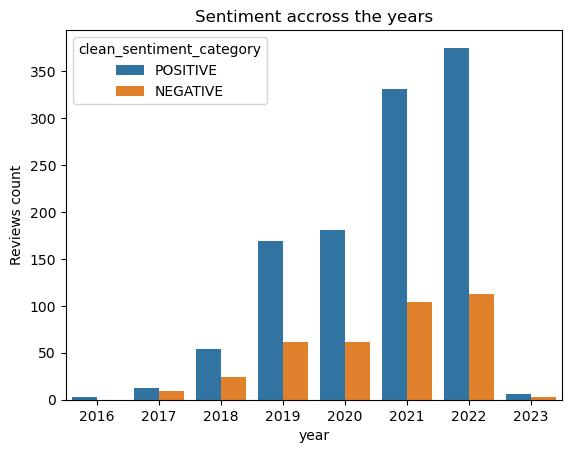

In [36]:
# Create a new column called "year" which is the year of the "review_date".
runway['year'] = runway['review_date'].dt.year

# Create a new dataframe of review counts by "year" and "cleaned_sentiment_category".
chart_data = runway.groupby(['year', 'clean_sentiment_category'], as_index=False)['user_id'].count()
chart_data.columns = ['year', 'clean_sentiment_category', 'cnt']
# Create a bar plot showing the count of reviews for each sentiment category over the years.
sns.barplot(data=chart_data, x='year', y='cnt', hue='clean_sentiment_category', errorbar=None)
plt.title('Sentiment accross the years')
plt.xlabel('year')
plt.ylabel('Reviews count')
plt.show()

## Task 6: Does Cleaning Text Matter?

It seems like the amount of positive reviews increased dramatically in 2021. Potentially a revamp of the customer experience, product quality, more customers, or something else we don't have data for. 

From a business context, digging into the common words/n-grams of the positive reviews can be revealing as to what customers love about the products. Doing the same for the negative reviews can be just as informative for what they don't love (i.e. sizing issues, rental service, etc.). 

Now let's test the previous comment on preprocessing text. Does it matter for sentiment analysis?

In this task, you will build another sentiment analysis pipeline but, in this case, for the non-cleaned `review_text`. Then, you will compare the output from the two pipelines to understand if the cleaning made a difference in categorizing sentiment.

Steps:
- Duplicate the steps from the previous exercise to run a sentiment analysis pipeline. Save as `sent_analysis_2`.
- Parse the output and save as `sentiment_category` and `sentiment_score`.
- Create a confusion matrix using `pd.crosstab()` comparing the output of `clean_sentiment_category` and `sentiment_category`.

In [39]:
# Create a new sentiment analysis output for "review_text".
sent_analysis_2 = sentimentAnalysis(list(runway['review_text']))

# Parse the output into "sentiment_category" and "sentiment_score".
runway['sentiment_category'] = [s['label'] for s in sent_analysis_2]
runway['sentiment_score'] = [s['score'] for s in sent_analysis_2]
# Print the confusion matrix comparing the two sentiment category outputs.
display(pd.crosstab(runway['clean_sentiment_category'], runway['sentiment_category']))

sentiment_category,NEGATIVE,POSITIVE
clean_sentiment_category,,
NEGATIVE,375,0
POSITIVE,0,1131


Based on the previous results, the sentiment of the review was pretty much the same with cleaned text. We can use the original text to perform further analysis. Again, this is context dependent, so be sure to think through the benefits of cleaning vs. leaving the text as is. 

Transformers, such as those on Hugging Face, are a component of machine learning / deep learning models which are designed to learn sequential data. Using a concept known as "self-attention", they use other tokens (words) in the sequence (sentence) to build an understanding of a specific token (word).

All of this to say (in a simplified manner) transformers, specifically those trained on VERY large datasets, work well on unstructured, un-cleaned text because it takes the whole sentence into context. And every piece adds to that context.

## Task 7: Embeddings

In the next task, we will switch gears to exploring another common use case for Hugging Face and transformers - text embeddings. 

Embeddings, in a very simplistic definition, are a vector (numerical) representation of something within n-dimensions. In this case, they are text embeddings.  Embeddings are useful because they represent human language to computers which enables a more sophisticated execution of similarity, text generation, semantic search, and the like. This can be extremely valuable for business tasks such as recommendations and searching within websites or products.

No we will try this out on the `rented for` column using the `sentence_transformer` [package](https://huggingface.co/sentence-transformers). The model you'll use is the BERT-based ["all-MiniLM-L6-v2" model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) which is a transformer that maps sentences and paragraphs to an n-dimensional vector.

Steps:
- Instantiate a new instance of `SentenceTransformer` using the specified model (`model_id`). Save as `model`.
- Generate an embedding for each review text using `model.encode()`. Save as `embeddings`.
- Print the shape of the new embeddings array.

In [44]:
model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Instantiate a new SentenceTransformer object.
model = SentenceTransformer(model_id)

# Generate the embeddings for the "rented for" column.
embeddings = model.encode(list(runway['rented for']))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [46]:
print(embeddings.shape)

(1506, 384)


## Task 8: Clustering

The `all-MiniLM-L6-v2` model outputs embeddings of 384 dimensions. A higher-dimensional embedding can capture more of the relationship between words which is fantastic!

However, for some tasks, such as clustering, it can be a challenge. Clustering tends to perform poorly with higher dimensions of data (a.k.a the Curse of Dimensionality), which poses a common challenge in text mining and NLP. Therefore, dimensionality reduction is often employed in order to calculate distance (e.g. Euclidean) between embeddings, then calculate clusters.

Since the transformer is constructed in such a way to be better at learning context, text - words, sentences, documents - that are similar should have similar vectors and therefore be closer together (i.e. in the same cluster).

Understanding which embeddings are closer together can then be used to determine which products, users, reviews, etc. are similar to each other. This is an important step in common method for building recommendations.

In this task, we'll conduct dimensionality reduction using the `TSNE` module from the `sklearn` package.

- Import `TSNE` from `sklearn.manifold`.
- Create a new TSNE object using the defined input parameters. Save as `tsne`.
- Fit the `tsne` model with the saved embeddings. Save this as `tsne_dims`.

In [50]:
# Import TSNE
from sklearn.manifold import TSNE

# Instantiate a new TSNE object. 
tsne=TSNE(n_components=2, perplexity=15, random_state=69, init='random', learning_rate=200)

# Generate the tsne dimensions using the saved embeddings.
tsne_dims = tsne.fit_transform(embeddings)

/opt/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [52]:
print(tsne_dims.shape)

(1506, 2)


## Task 9: Visualizing the Clusters

Now each embedding is 2-dimensional. You don't need to be so drastic in dimensionality reduction for clustering, i.e. use explained variance ratio to determine the right number of components, but is important for visualizing the clusters.

With these smaller vectors, let's move on to generating basic clusters (the average of each category) and building a visualization for them!

Steps:
- Extract the x and y dimensions from the `tsne_dims` result. Save as new columns in `runway` named `x` and `y`, respectively.
- Use `seaborn.scatterplot` to create a new scatterplot using the x and y dimensions and `category` as the "hue".
- Set the title as `Embeddings visualized for 'rented for' reasons and category using t-SNE`.

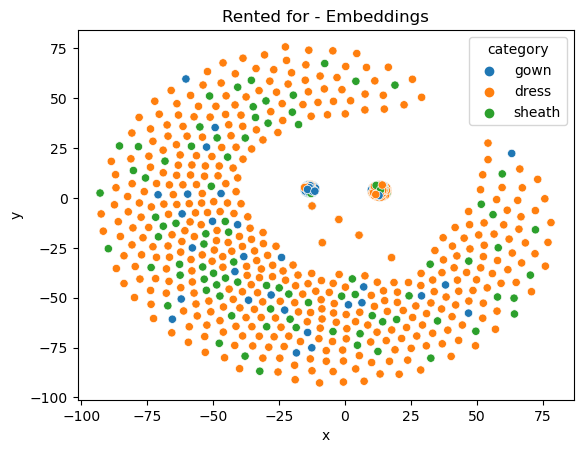

In [57]:
# Parse out the x and y dimensions from the tsne output.
runway['x'] = [x for x, y in tsne_dims]
runway['y'] = [y for x, y in tsne_dims]

# Create the scatterplot
sns.scatterplot(x='x', y='y', hue='category', data=runway)
plt.title('Rented for - Embeddings')
plt.show()

## Task 10: Semantic Search

The plot is showing us all of the review embeddings - based on the "rented_for" column - in a two-dimensional space (since our eyes can't handle 384 dimensions)! The color is indicating the type of item rented, i.e. "dress", "gown", "sheath".

There are clearly two main clusters in this dataset for "rented for" - the mainly blue cluster and the mainly orange one. The blue cluster consists primarily of gowns while the other is mainly dresses.

This is a simple example yet still very informative about how customers rent items for which types of occasions.

Embeddings are not only cool to visualize, as mentioned above, they also facilitate "semantic search". Semantic search denotes "searching with meaning" and with context when available. The goal is to infer what the user's intent is then find the most relevant results. This is different from "lexical search" where a search engine looks for literal matches of a query (or defined variants). Both have their strengths and weaknesses, which we encourage you to research further.

Semantic search can be incredibly powerful in a customer experience setting. Specifically, they can help with recommendations (i.e. which product is similar based on reviews, descriptions, etc.) and - obviously - search (i.e. find me products with these phrases or words in their reviews). 

In this task, we'll build a simple semantic search pipeline using the `sentence-transformer` package.

- First, generate an embedding of the pre-defined query using the same model object saved above. Save this query embedding as `query_emb`.
- With the `semantic_search()` function, use the query embedding and the other embeddings to get the top three "hits", i.e. most similar items by review.
- Use a for-loop to print the category and rented for reason for each hit.

In [60]:
# Define query
query = "a gorgeous and flattering dress"

# Embed query
query_emb = model.encode(query, convert_to_tensor=True)

# Calculate similarity between query and item embeddings
hits = semantic_search(query_emb, embeddings, top_k=3)

# Print top similar items
for hit in hits[0]:
    idx = hit['corpus_id']
    print('ITEM ID: ', runway.iloc[idx]['item_id'])
    print('RENTED FOR: ', runway.iloc[idx]['rented for'])
    print('REVIEW: ', runway.iloc[idx]['review_text'])

ITEM ID:  123793
RENTED FOR:  wedding
REVIEW:  i am very petite and with heels the regular was just the right length i wished it was a tiny bit tighter in the waist but it still was gorgeous it was not nearly as heavy as i thought it would be and didnt feel so fragile that sequins were going to constantly come off amazing dress
ITEM ID:  652189
RENTED FOR:  wedding
REVIEW:  even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant wear a bra and because the neck is such a scoopneck it makes the neckline a little strange if you have a chest and dont wear onei ended up getting one of those stick on bras and the dress looked much betterits much pinker than the model picture which was a pleasant surprisepretty dress comfortable just a little awkward fitting in the chest area if you have anything larger than an abuy the stick on bra
ITEM ID:  1498329
RENTED FOR:  wedding
REVIEW:  the dress was g

## Task 11: Generate New Marketing Material

The semantic search returned three different items that appear to be similar to what we were searching for, i.e. "the dress was gorgeous" and "this dress was a great fit". With some fine-tuning, you can achieve even greater performance. We can also notice some constructive feedback on other parts of the dress. Further investigation can reveal important insights for the business team.

Let's again switch gears for this final task. Let's generate some new text based on a prompt. For example, you want to create some brainstorming material for a new marketing campaign.

In this task, we'll switch back to the `pipeline()` module.

- Instantiate a text generation pipeline using `model = "gpt2"` as the input parameter. Save as `generator`.
- Using this generator, create 1 new piece of text based on the pre-defined prompt. Save as `output`.
- Print the prompt and the output.

In [64]:
# Instantiate the pipeline for generating text
generator = pipeline(model='gpt2')

# Pre-defined prompt
prompt = "New for this winter season, a lovely dress that"

# Use the prompt as input to the generator to return output.
output = generator(prompt, num_return_sequences=2, return_full_text=True)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [65]:
# Print the generated text.
print(output[0]['generated_text'])

New for this winter season, a lovely dress that is not too revealing and an extremely simple but stylish gift for you or your family.


These are the perfect dress for Christmas, because you'll have a Christmas gift for everyone. No need to
